In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
lfw_path = "lfw-deepfunneled"   # path to extracted LFW dataset
target_person = "George_W_Bush" # choose any person in LFW
img_size = 128
model_file = "lfw_face_classifier.h5"

#Note: Use Kaggle to download the LFW dataet  link: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset?resource=download 

In [3]:
#Loading the LFW dataset
def load_lfw_data(lfw_path, target_person, img_size=128):
    X, y = [], []
    for person in os.listdir(lfw_path):
        person_path = os.path.join(lfw_path, person)
        if not os.path.isdir(person_path):
            continue
        label = 1 if person == target_person else 0
        for img_name in os.listdir(person_path):
            img_path = os.path.join(person_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(label)
    X = np.array(X, dtype="float32") / 255.0
    y = np.array(y)
    return X, y

In [4]:
#Training and saving the model
def train_model():
    print("📂 Loading dataset...")
    X, y = load_lfw_data(lfw_path, target_person, img_size)
    print(f"✅ Loaded {len(X)} images. Positive: {np.sum(y)}, Negative: {len(y)-np.sum(y)}")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(img_size,img_size,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    print("🚀 Training model...")
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

    model.save(model_file)
    print(f"✅ Model saved as {model_file}")

In [5]:
#Evaluating the model
def test_webcam():
    print("📂 Loading model...")
    model = load_model(model_file)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    cam = cv2.VideoCapture(0)

    print("🎥 Starting webcam... Press ESC to exit.")
    while True:
        ret, frame = cam.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x,y,w,h) in faces:
            face_img = frame[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (img_size,img_size))
            face_img = np.expand_dims(face_img/255.0, axis=0)

            pred = model.predict(face_img)[0][0]
            label = target_person if pred > 0.5 else "Other"

            color = (0,255,0) if label == target_person else (0,0,255)
            cv2.putText(frame, f"{label} ({pred:.2f})", (x,y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            cv2.rectangle(frame, (x,y), (x+w,y+h), color, 2)

        cv2.imshow("Facial Recognition (LFW)", frame)
        if cv2.waitKey(1) & 0xFF == 27:  # ESC to quit
            break

    cam.release()
    cv2.destroyAllWindows()

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def test_on_dataset():
    print("📂 Loading dataset for testing...")
    X, y = load_lfw_data(lfw_path, target_person, img_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    model = load_model(model_file)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    print("✅ Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Other", target_person]))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Other", target_person],
                yticklabels=["Other", target_person])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
if __name__ == "__main__":
    if not os.path.exists(model_file):
        train_model()

📂 Loading dataset...
✅ Loaded 13233 images. Positive: 530, Negative: 12703


c:\Users\Rugved\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

🚀 Training model...
Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.9582 - loss: 0.1887 - val_accuracy: 0.9600 - val_loss: 0.1575
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - accuracy: 0.9599 - loss: 0.1457 - val_accuracy: 0.9600 - val_loss: 0.1328
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.9599 - loss: 0.1132 - val_accuracy: 0.9600 - val_loss: 0.1011
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 43s 131ms/step - accuracy: 0.9601 - loss: 0.0908 - val_accuracy: 0.9626 - val_loss: 0.0901
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 46s 139ms/step - accuracy: 0.9672 - loss: 0.0704 - val_accuracy: 0.9686 - val_loss: 0.0738
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 50s 150ms/step - accuracy: 0.9752 - loss: 0.0603 - val_accuracy: 0.9694 - val_loss: 0.0695
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 49s 148ms/step - accuracy: 0.9823 - loss: 0.0461 - val_accuracy: 0.9732 - val_loss: 0.0741
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 81s 145ms/step - accura

✅ Model saved as lfw_face_classifier.h5
📂 Loading model...


🎥 Starting webcam... Press ESC to exit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


📂 Loading dataset for testing...


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
✅ Classification Report:
               precision    recall  f1-score   support

        Other       0.98      1.00      0.99      2541
George_W_Bush       0.96      0.63      0.76       106

     accuracy                           0.98      2647
    macro avg       0.97      0.82      0.88      2647
 weighted avg       0.98      0.98      0.98      2647



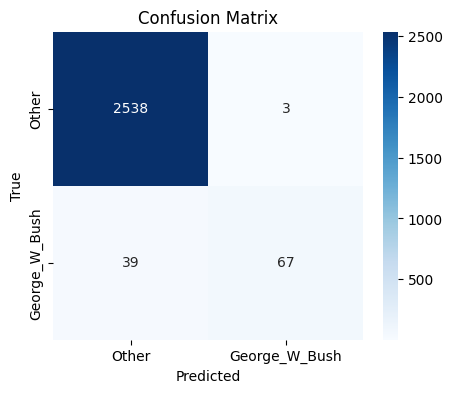

In [11]:
if __name__ == "__main__":
    if not os.path.exists(model_file):
        train_model()
    test_on_dataset()